<a href="https://colab.research.google.com/github/VinayV20/Projects/blob/main/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

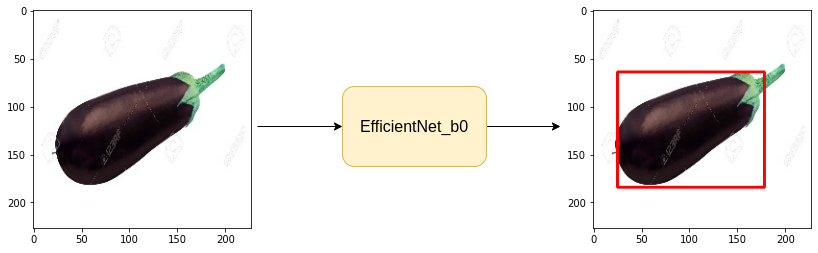

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rdvye9kd
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rdvye9kd
  Resolved https://github.com/albumentations-team/albumentations to commit c70e664e060bfd7463c20674927aed217f72d437
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 26.92 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE='/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'
NUM_COR = 4


In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

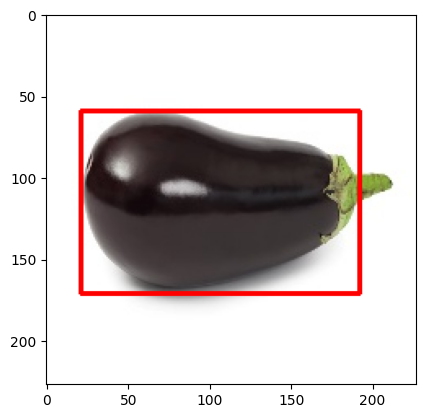

In [ ]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1=(row.xmin,row.ymin)
pt2 = (row.xmax,row.ymax)
bnd_box_img = cv2.rectangle(img, pt1,pt2,(255,0,0),2)
plt.imshow(bnd_box_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size =0.20, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A #library for data augmentation

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))



# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self,df,augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    xmin=row.xmin
    ymin=row.ymin
    xmax=row.xmax
    ymax=row.ymax

    bbox = [[xmin,ymin,xmax,ymax]]

    img_path=DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image=img, bboxes = bbox, class_labels=[None])
      img = data['image']
      bbox=data['bboxes'][0]
    img = torch.from_numpy(img).permute(2,0,1) / 255.0 #(h,w,c) -> (c,h,w)
    bbox = torch.Tensor(bbox)

    return img,bbox







In [ ]:
trainset=ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"total examples in the trainset : {len(trainset)}")
print(f"total examples in the validset : {len(validset)}")

total examples in the trainset : 148
total examples in the validset : 38


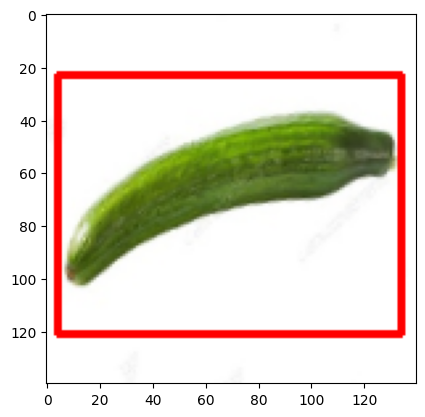

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE,shuffle=True)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images,bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME,pretrained=True, num_classes=4)
  def forward(self,images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes



In [ ]:
model = ObjLocModel()
model.to(DEVICE);


In [ ]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model,dataloader, optimizer):
  total_loss = 0.0
  model.train() # Dropout layer should be on
  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)


In [ ]:
def eval_fn(model,dataloader):
  total_loss = 0.0
  model.eval() # Dropout layer should be off
  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)


      total_loss += loss.item()
  return total_loss / len(dataloader)


#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Weights are saved')
    best_valid_loss = valid_loss

  print(f"epoch : {i+1} train loss : {train_loss} valid_loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 1 train loss : 5356.381372070313 valid_loss: 2627.072021484375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 2 train loss : 1899.54111328125 valid_loss: 3148.8323567708335


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 3 train loss : 1099.0091125488282 valid_loss: 561.8477478027344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 4 train loss : 686.8111938476562 valid_loss: 188.22806294759116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 5 train loss : 483.4828216552734 valid_loss: 139.3350601196289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 6 train loss : 337.31861114501953 valid_loss: 131.38585917154947


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 7 train loss : 280.733381652832 valid_loss: 187.9420623779297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 8 train loss : 217.51931457519532 valid_loss: 120.71822611490886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 9 train loss : 171.19940948486328 valid_loss: 101.1292495727539


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 10 train loss : 123.64435424804688 valid_loss: 127.2488784790039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 11 train loss : 129.2873847961426 valid_loss: 121.15839385986328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 12 train loss : 114.06246490478516 valid_loss: 88.45715459187825


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 13 train loss : 101.31631851196289 valid_loss: 100.73030090332031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 14 train loss : 96.1169937133789 valid_loss: 99.88584391276042


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 15 train loss : 88.41927299499511 valid_loss: 78.96833801269531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 16 train loss : 80.24195289611816 valid_loss: 80.03610483805339


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 17 train loss : 76.65952033996582 valid_loss: 74.08415222167969


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 18 train loss : 71.56834106445312 valid_loss: 82.79610188802083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 19 train loss : 62.32644119262695 valid_loss: 69.86393864949544


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 20 train loss : 57.19024486541748 valid_loss: 78.43958282470703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 21 train loss : 58.6396671295166 valid_loss: 63.87722396850586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 22 train loss : 63.10453720092774 valid_loss: 79.7242800394694


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 23 train loss : 60.791419410705565 valid_loss: 88.38861592610677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 24 train loss : 46.63332557678223 valid_loss: 69.13679504394531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 25 train loss : 54.29713382720947 valid_loss: 85.6105359395345


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 26 train loss : 46.367984199523924 valid_loss: 72.68172963460286


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 27 train loss : 40.45038776397705 valid_loss: 80.61873626708984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 28 train loss : 41.60934295654297 valid_loss: 68.85146077473958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 29 train loss : 45.97507743835449 valid_loss: 63.07960510253906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 30 train loss : 35.5106746673584 valid_loss: 84.3812993367513


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 31 train loss : 39.68533411026001 valid_loss: 73.06437683105469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 32 train loss : 52.18021106719971 valid_loss: 62.23137537638346


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 33 train loss : 47.734842681884764 valid_loss: 59.288934071858726


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 34 train loss : 40.22850322723389 valid_loss: 55.61695098876953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
epoch : 35 train loss : 40.99210147857666 valid_loss: 43.34029642740885


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 36 train loss : 40.39566307067871 valid_loss: 55.35429128011068


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 37 train loss : 52.958685874938965 valid_loss: 65.54797617594402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 38 train loss : 41.71061668395996 valid_loss: 60.387795766194664


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 39 train loss : 41.67763843536377 valid_loss: 81.65931193033855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 40 train loss : 47.59884777069092 valid_loss: 72.40197626749675


#Inference

In [ ]:
import utils

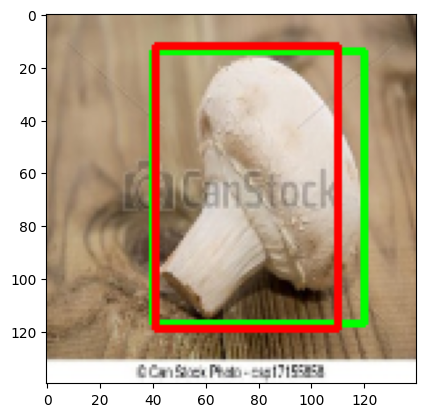

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
  image, gt_bbox = validset[23]
  image = image.unsqueeze(0).to(DEVICE) #(c,h,w)->(bs,c,h,w)
  out_bbox = model(image)
  utils.compare_plots(image,gt_bbox, out_bbox)